In [1]:
import numpy as np
import os,sys
import math
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.params import params_prob, params_LSC, params_PSC
from utils.generation import LSC, PSC

In [3]:
exp_type = 'GOP_NET'
data_path = os.path.join(os.getcwd(),os.pardir,'results',exp_type)
from utils.helperFunctions import circ_dis_np
from utils.ProbModel import position2phase_modules

In [4]:
# read npy files
z_record_net = np.load(os.path.join(data_path,'z_record_net.npy'))
phi_record_net = np.load(os.path.join(data_path,'phi_record_net.npy'))
z_record_GOP = np.load(os.path.join(data_path,'z_record_GOP.npy'))
phi_record_GOP = np.load(os.path.join(data_path,'phi_record_GOP.npy'))

u_HPC = np.load(os.path.join(data_path,'u_HPC.npy'))
u_grids = np.load(os.path.join(data_path,'u_grids.npy'))
I_mec = np.load(os.path.join(data_path,'I_mec.npy'))
activation_p_np = np.load(os.path.join(data_path,'activation_p_np.npy'))
activation_gs_np = np.load(os.path.join(data_path,'activation_gs_np.npy'))

In [5]:
LSCModel = LSC(params_LSC)
PSCModel = PSC(params_PSC)
z_candidates = LSCModel.mu_p
phi_candidates = PSCModel.mu_g 
z_candidates = np.array(z_candidates)
phi_candidates = np.array(phi_candidates)

In [6]:
# calculate posterior
def calculate_posterior(z, phi, Ig, Ip):
    psi_z = position2phase_modules(z, params_PSC)
    log_prior = 0
    log_likelihood_grid = 0
    sigma_phi = params_PSC['sigma_phi']
    sigma_phi = np.array(sigma_phi)
    sigma_p = params_LSC['sigma_p']
    sigma_p = np.array(sigma_p)
    sigma_g = params_PSC['sigma_g']
    sigma_g = np.array(sigma_g)
    for i in range(params_PSC['M']):
        dis_1 = circ_dis_np(phi_candidates, phi[i])
        fg = np.exp(-dis_1**2 / (4 * params_PSC['a_gs_np'][i]**2))
        log_likelihood_grid -= np.sum((Ig[i, :] - fg)**2) / sigma_g[i]**2
        dis_2 = circ_dis_np(phi[i], psi_z[i])
        log_prior -= 1 / (sigma_phi[i]**2) * np.exp(-dis_2**2/8/params_PSC['a_gs_np'][i]**2) * dis_2**2
    dis_x = z_candidates - z
    fp = np.exp(-dis_x**2 / (4 * params_LSC['a_p'] ** 2))
    log_likelihood_place = -np.sum((Ip - fp)**2) / params_LSC['sigma_p']**2
    log_posterior = log_likelihood_grid + log_prior + log_likelihood_place

    return log_posterior

In [7]:
z_record_GOP = z_record_GOP[1:, :]
phi_record_GOP = phi_record_GOP[1:, :]

In [61]:
T = z_record_net.shape[0]
print(T)
T_short = 3000

5000


In [9]:
log_posterior_nets = []
log_posterior_GOPs = []
for t in range(T):
    log_posterior_net = calculate_posterior(z_record_net[t, :], phi_record_net[t, :], activation_gs_np, activation_p_np)
    log_posterior_GOP = calculate_posterior(z_record_GOP[t, :], phi_record_GOP[t, :], activation_gs_np, activation_p_np)
    log_posterior_nets.append(log_posterior_net)
    log_posterior_GOPs.append(log_posterior_GOP)

log_posterior_nets = np.array(log_posterior_nets)
log_posterior_GOPs = np.array(log_posterior_GOPs)


In [23]:
save_path = os.path.join(data_path, 'figures')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [42]:
fontsize = 22
linewidth = 3.
figsize=(6, 5)
legend_fontsize = 18
# color=['#FF6961', '#B19CD9', '#77DD77']
# color=['blue', 'orange', 'grey']
# color = ['#F5E09B','#B7DBE3','#DFE1E2']
color = ['#F3C846', '#9ec6db', '#B19CD9']

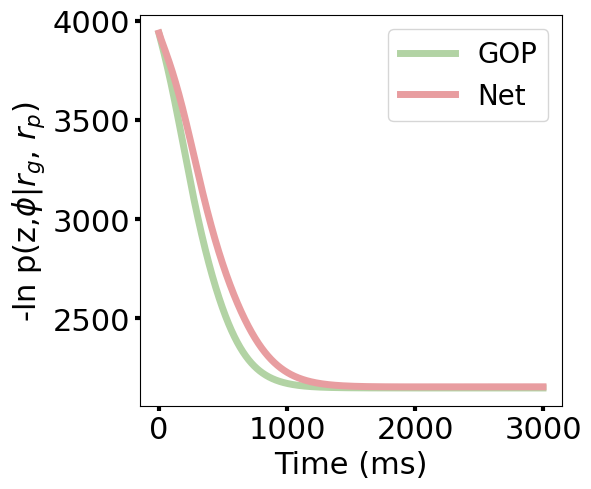

In [96]:
fontsize = 22
linewidth = 3.
figsize=(6, 5)
legend_fontsize = 20
# color=['#FF6961', '#B19CD9', '#77DD77']
# color=['blue', 'orange', 'grey']
# color = ['#F5E09B','#B7DBE3','#DFE1E2']
# color = ['#F3C846', '#9ec6db', '#B19CD9']
color = ['#E89DA0','#88CEE6','#B2D3A4']
plt.figure(figsize=(6, 5))
linewidth_logp = 5
plt.plot(-log_posterior_GOPs[:T_short], color=color[2], linewidth=linewidth_logp, label='GOP')
plt.plot(-log_posterior_nets[:T_short], color=color[0], linewidth=linewidth_logp, label='Net')
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('-ln p(z,$\phi$|$r_g$, $r_p$)', fontsize=fontsize)
plt.gca().tick_params(width=linewidth)
plt.gca().tick_params(labelsize=fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'log_posterior.png'))

In [19]:
pos_gt = 101.5
phi_gt = position2phase_modules(pos_gt, params_PSC)
phi_gt = np.array(phi_gt)
print(pos_gt, phi_gt)

101.5 [5.23598776 3.14159265 0.9424778 ]


In [74]:
color1 = (78/255, 183/255, 233/255)
color2 = (220/255, 64/255, 26/255)

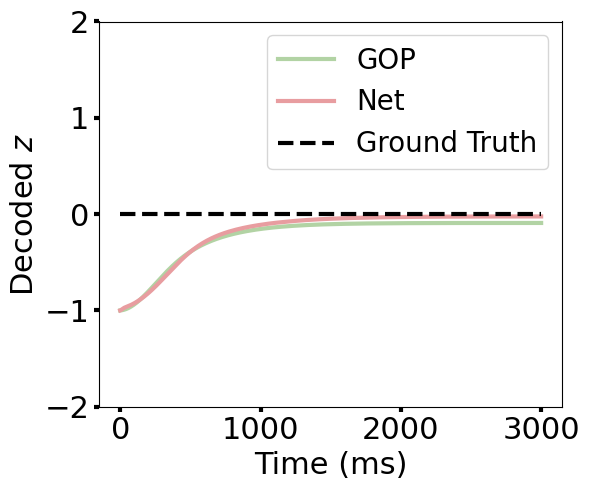

In [103]:
def plot_z_decoding(z_t1,z_t2,z_gt,label1,label2,savepath,fontsize=22,linewidth=3.,fontsize_legend=20):
    plt.figure(figsize=(6, 5))
    alpha = 1.0
    plt.plot(z_t2[:T_short], color = color[2], label = label2,linewidth=linewidth)
    plt.plot(z_t1[:T_short], color = color[0], label = label1,linewidth=linewidth)
    T = len(z_t1)
    plt.plot([0, T_short], [0, 0], 'k--', linewidth=linewidth, alpha=alpha,label = 'Ground Truth')
    # plt.xlabel('Iterations', fontsize=fontsize)
    plt.xlabel('Time (ms)', fontsize=fontsize)
    plt.ylabel('Decoded $z$', fontsize=fontsize)
    plt.gca().tick_params(width=linewidth)
    plt.gca().tick_params(labelsize=fontsize)
    plt.ylim([-2, +2])
    plt.legend(fontsize=fontsize_legend)
    plt.tight_layout()
    filename = os.path.join(savepath, 'z_decoding_sup.png')
    plt.savefig(filename)
    plt.show()

plot_z_decoding(z_record_net[:,0]-pos_gt,z_record_GOP[:,0]-pos_gt,pos_gt,'Net','GOP',save_path)


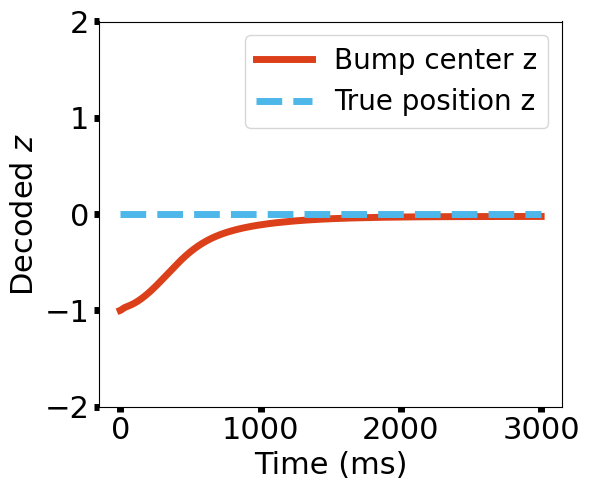

In [82]:
def plot_z_decoding(z_t ,z_gt,savepath,fontsize=22,linewidth=5.,fontsize_legend=20):
    plt.figure(figsize=(6, 5))
    alpha = 1.0
    plt.plot(z_t[:T_short], color = color2, label = 'Bump center z',linewidth=linewidth)
    plt.plot([0, T_short], [0, 0], '--', linewidth=linewidth,color = color1, alpha=alpha,label ='True position z')
    # plt.xlabel('Iterations', fontsize=fontsize)
    plt.xlabel('Time (ms)', fontsize=fontsize)
    plt.ylabel('Decoded $z$', fontsize=fontsize)
    plt.gca().tick_params(width=linewidth)
    plt.gca().tick_params(labelsize=fontsize)
    plt.ylim([-2, +2])
    plt.legend(fontsize=fontsize_legend)
    plt.tight_layout()
    filename = os.path.join(savepath, 'z_decoding.png')
    plt.savefig(filename)
    plt.show()

plot_z_decoding(z_record_net[:,0]-pos_gt,pos_gt,save_path)

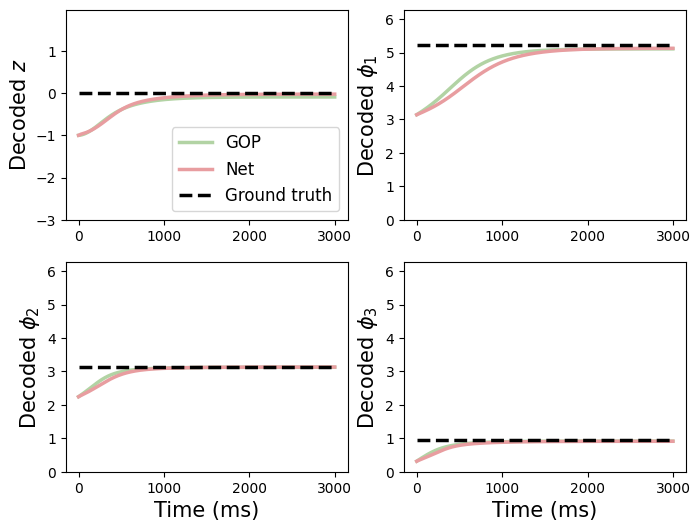

In [90]:

def plot_zphi_decoding(z_t1,z_t2,z_gt,phi_t1,phi_t2,phi_gt,label1,label2,modules,savepath,fontsize=15,linewidth=2.5):
    # each cols plot at most 2 modules
    cols = 2
    z_t1 = z_t1[:T_short] 
    z_t2 = z_t2[:T_short]
    phi_t1 = phi_t1[:T_short]
    phi_t2 = phi_t2[:T_short]
    total_modules = modules + 1 # M + 1
    if total_modules <= cols:
        rows = 1
    else:
        rows = math.ceil(total_modules / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(8, 6))
    T = T_short
    for i in range(total_modules):
        if modules <= cols:
            ax = axs[i]
        else:
            ax = axs[i // cols, i % cols]
        if i == 0: # z_t1,z_t2
            z_t2 = z_t2 - pos_gt
            z_t1 = z_t1 - pos_gt
            ax.plot(z_t2, color=color[2], label=label2, linewidth=linewidth)
            ax.plot(z_t1, color=color[0], label=label1, linewidth=linewidth)
            ax.plot([0, T], [0, 0], 'k--', linewidth=linewidth, label = 'Ground truth')
            # ax.set_xlabel('Iterations', fontsize=fontsize)
            ax.set_ylabel('Decoded $z$', fontsize=fontsize)
            ax.set_ylim([min(z_t1)-2, max(z_t1)+2])
            ax.legend(fontsize=12)
        else:
            if (i == total_modules - 1) or (i == total_modules-2):
                # ax.set_xlabel('Iterations', fontsize=fontsize)
                ax.set_xlabel('Time (ms)', fontsize=fontsize)
            ax.plot(phi_t2[:,i-1], color=color[2], label=label2, linewidth=linewidth)
            ax.plot(phi_t1[:,i-1], color=color[0], label=label1, linewidth=linewidth)
            ax.plot([0, T], [phi_gt[i-1], phi_gt[i-1]], 'k--', linewidth=linewidth)
            # ax.set_xlabel('Iterations', fontsize=fontsize)
            ax.set_ylabel(f'Decoded $\phi_{i}$ ', fontsize=fontsize)
            # ax.set_ylim([0, 2*np.pi])
            min_val = min([min(phi_t1[:,i-1]), min(phi_t2[:,i-1]), phi_gt[i-1], 0])
            max_val = max([max(phi_t1[:,i-1]), max(phi_t2[:,i-1]), phi_gt[i-1], 2*np.pi])
            # min_val = max([min(phi_t1[:,i-1]), min(phi_t2[:,i-1]), phi_gt[i-1], 0])
            # max_val = min([max(phi_t1[:,i-1]), max(phi_t2[:,i-1]), phi_gt[i-1], 2*np.pi])

            ax.set_ylim([min_val, max_val])

    for i in range(total_modules, rows * cols):
        fig.delaxes(axs[i // cols, i % cols])
    filename = os.path.join(savepath, 'zphi_decoding.png')
    plt.savefig(filename)
    plt.show()

plot_zphi_decoding(z_record_net, z_record_GOP, pos_gt, phi_record_net, phi_record_GOP, phi_gt, 'Net', 'GOP', params_PSC['M'], save_path)


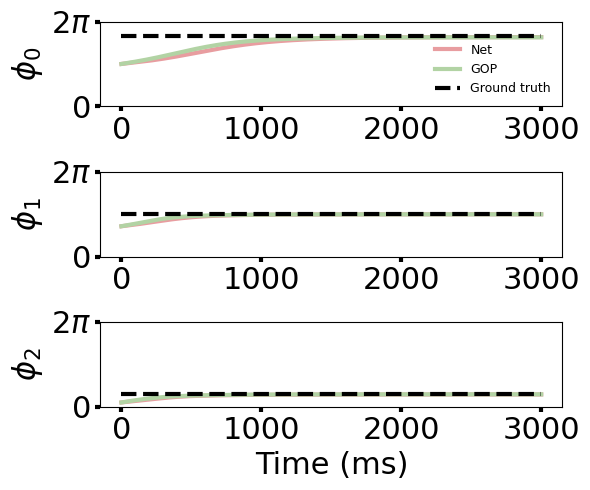

In [91]:
# 3 modules decoded phi
fig, axs = plt.subplots(3,1, figsize=(6, 5))
for i in range(3):
    ax = axs[i]
    ax.plot(phi_record_net[:T_short,i], color=color[0], label='Net', linewidth=linewidth)
    ax.plot(phi_record_GOP[:T_short,i], color=color[2], label='GOP', linewidth=linewidth)
    ax.plot([0, T_short], [phi_gt[i], phi_gt[i]], 'k--', linewidth=linewidth, label='Ground truth')
    if i == 2:
        # ax.set_xlabel('Iterations', fontsize=fontsize)
        ax.set_xlabel('Time (ms)', fontsize=fontsize)
    ax.set_ylabel(f'$\phi_{i}$', fontsize=fontsize)
    ax.set_ylim([0, 2*np.pi])
    if i == 0:
        ax.legend(fontsize=9,frameon=False)
    # tick_params
    ax.tick_params(width=linewidth)
    ax.tick_params(labelsize=fontsize)
    # y label [0, 2pi]
    ax.set_yticks([0, 2*np.pi], ['$0$', '$2\pi$'])

plt.tight_layout()
filename = os.path.join(save_path, 'phi_decoding.png')
plt.savefig(filename)
plt.show()

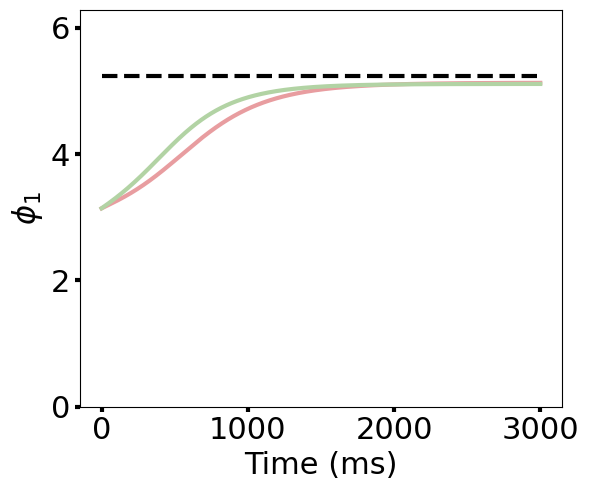

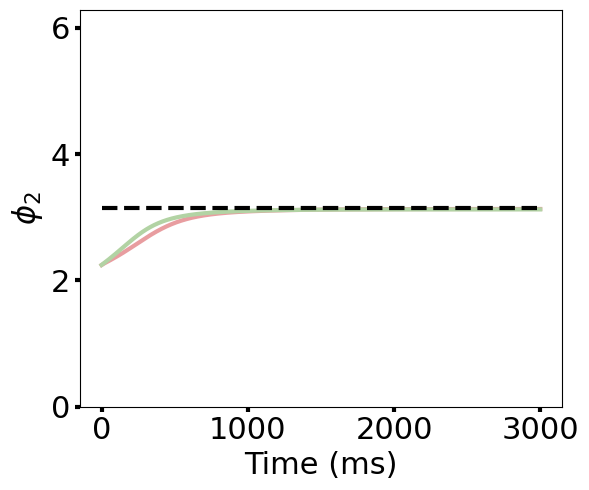

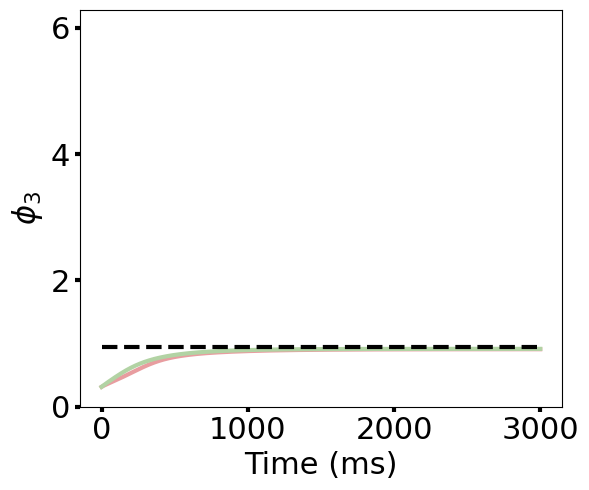

In [104]:
# plot and save respectively for each module phi
for i in range(3):
    plt.figure(figsize=(6, 5))
    plt.plot(phi_record_net[:T_short,i], color=color[0], label='Net', linewidth=linewidth)
    plt.plot(phi_record_GOP[:T_short,i], color=color[2], label='GOP', linewidth=linewidth)
    plt.plot([0, T_short], [phi_gt[i], phi_gt[i]], 'k--', linewidth=linewidth, label='Ground truth')
    plt.xlabel('Time (ms)', fontsize=fontsize)
    plt.ylabel(f'$\phi_{i+1}$', fontsize=fontsize)
    plt.gca().tick_params(width=linewidth)
    plt.gca().tick_params(labelsize=fontsize)
    plt.ylim([0, 2*np.pi])
    # plt.legend(fontsize=legend_fontsize)
    plt.tight_layout()
    filename = os.path.join(save_path, f'phi_decoding_{i}.png')
    plt.savefig(filename)
    plt.show()